## Introductie
In deze EDA ga ik de [hunting mantis](https://www.kaggle.com/datasets/stealthtechnologies/predict-hunting-success-rate-of-a-chinese-mantis) dataset onderzoeken, en een machine learning algoritme op trainen.
Uiteindelijk is het bedoeling om te kunnen voorspellen of een jacht van de mantis succesvol is gebasseerd op een aantal variabelen.
Om dit te kunnen doen zal de data eerst onderzocht moeten worden.





## EDA

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

### Inlezen

In [3]:
hunting_data = pd.read_csv("./data.csv")
hunting_data.index += 1
hunting_data.head()

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
1,0.32,31.25,Morning,True,0.81,6.600000,False,NaN,True,False,0
2,0.66,29.08,Afternoon,False,2.81,5.380000,False,Low,False,False,1
3,0.61,25.74,Evening,True,3.79,15.189246,True,Low,False,False,1
4,0.37,22.68,Morning,False,4.27,5.060000,True,Low,True,False,1
5,0.65,29.20,Afternoon,False,3.84,2.710000,False,High,False,False,1


In [4]:
hunting_data.shape

(300000, 11)

Alle kolommen en rijen zijn goed ingelezen, shape komt overeen met wat er op de site staat (300000x11).

In [5]:
codebook = {
    "attribute": hunting_data.columns,
    "unit": ["g/m^3", "Celcius", "NA", "True/False", "Minutes", "Cm", "True/False", "NA", "True/False", "True/False", "1/0"],
    "dtype": ["float64", "float64", "category", "bool", "float64", "float64", "bool", "category", "bool", "bool", "int64"],
    "description": [
        "Humidty level of enviroment",
        "Temperature of enviroment",
        "Time of the day",
        "Luring succes",
        "Time spent hunting",
        "Size of prey being hunted",
        "If mantis used an ambush",
        "Amount of food available",
        "If there are predators near",
        "If there is competition",
        "If the hunt was a succes"
    ]
}
pd.DataFrame(codebook)


,attribute,unit,dtype,description
0,Humidity Level,g/m^3,float64,Humidty level of enviroment
1,Temperature,Celcius,float64,Temperature of enviroment
2,Time of Day,NA,category,Time of the day
3,Luring Success,True/False,bool,Luring succes
4,Time Spent Hunting,Minutes,float64,Time spent hunting
5,Prey Size,Cm,float64,Size of prey being hunted
6,Ambush,True/False,bool,If mantis used an ambush
7,Food Availability,NA,category,Amount of food available
8,Predator Presence,True/False,bool,If there are predators near
9,Is Competition,True/False,bool,If there is competition


Deze dataframe bevat informatie over de attributen van de data

### Univariaat

In [6]:
pd.DataFrame({
  "isna": hunting_data.isna().sum()
})



,isna
Humidity Level,0
Temperature,0
Time of Day,0
Luring Success,0
Time Spent Hunting,0
Prey Size,0
Ambush,0
Food Availability,30212
Predator Presence,29708
Is Competition,30119


Er zijn een aantal missende waarden bij "Food Availability", "Predator Presence", "Is Competition". Ik wil bepalen of deze NA waarden willekeurig voorkomen.

In [7]:
def by_unit(*units):
    return [attribute for attribute, unit in zip(codebook["attribute"], codebook["unit"]) if unit in units]

<Axes: >

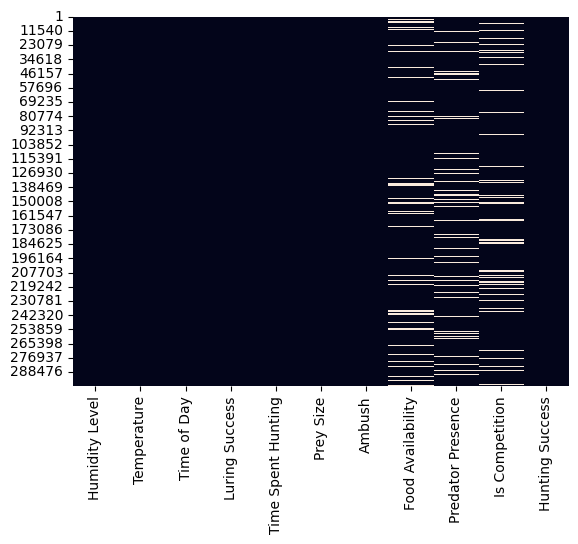

In [8]:
na_values = hunting_data.isna().astype(int)
sns.heatmap(na_values, cbar=False)

In [9]:
missing_stats = hunting_data.isna().sum() / hunting_data.shape[0] * 100
missing_stats

Humidity Level         0.000000
Temperature            0.000000
Time of Day            0.000000
Luring Success         0.000000
Time Spent Hunting     0.000000
Prey Size              0.000000
Ambush                 0.000000
Food Availability     10.070667
Predator Presence      9.902667
Is Competition        10.039667
Hunting Success        0.000000
dtype: float64

De 3 kolommen met na waarden bestaan voor ongeveer 10% uit NA waarden.
Ook lijkt er geen patroon zichtbaar in de heatmap, en blijken de NA waarden willekeurig te zijn.
Mogelijk kunnen de NA waarden ontstaan door andere variabelen, zoals geen voedsel door dat er op een verkeerd moment van de dag gejaagd werd of vochtigheid.



<Axes: xlabel='Food Availability', ylabel='Humidity Level'>

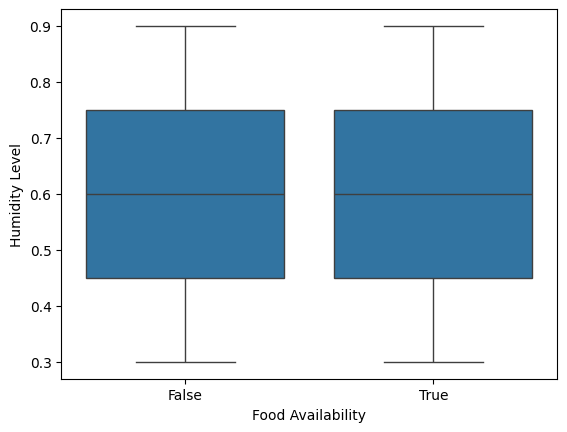

In [10]:
sns.boxplot(x = hunting_data["Food Availability"].isna(), y = hunting_data["Humidity Level"])

<Axes: xlabel='Food Availability', ylabel='count'>

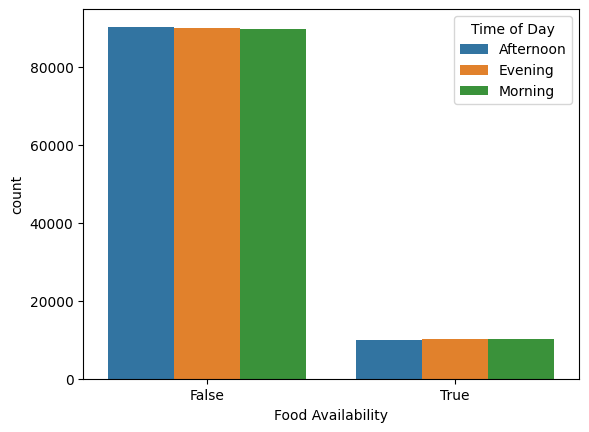

In [11]:
na_food = hunting_data["Food Availability"].isna()
sns.countplot(x = na_food, hue=hunting_data["Time of Day"])

Dit geeft weer dat andere variabelen waarschijnlijk geen invloed hebben op de NA waarden.
Om deze reden besluit ik om de NA waarden weg te gooien.

In [12]:
hunting_data = hunting_data.dropna()

In [13]:
hunting_data[by_unit("True/False")] = hunting_data[by_unit("True/False")].astype(int)


Om de distributies van numerieke attributen te visualiseren worden boxplotten en histogrammen gebruikt.

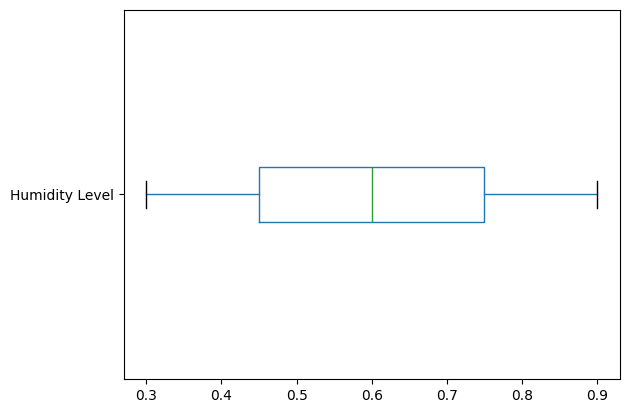

In [14]:
hunting_data[by_unit("g/m^3")].boxplot(vert=False, grid=False);

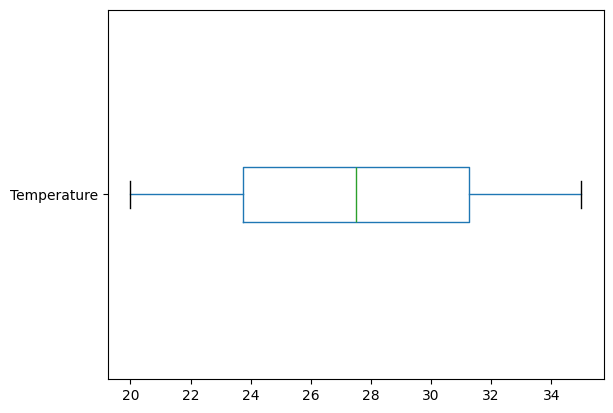

In [15]:
hunting_data[by_unit("Celcius")].boxplot(vert=False, grid=False);

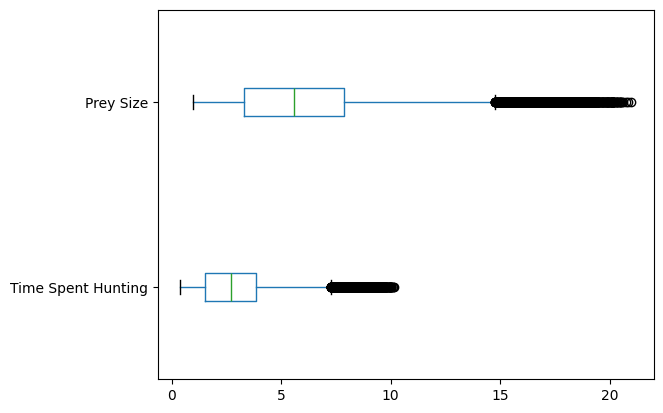

In [16]:
hunting_data[by_unit("Minutes", "Cm")].boxplot(vert=False, grid=False);

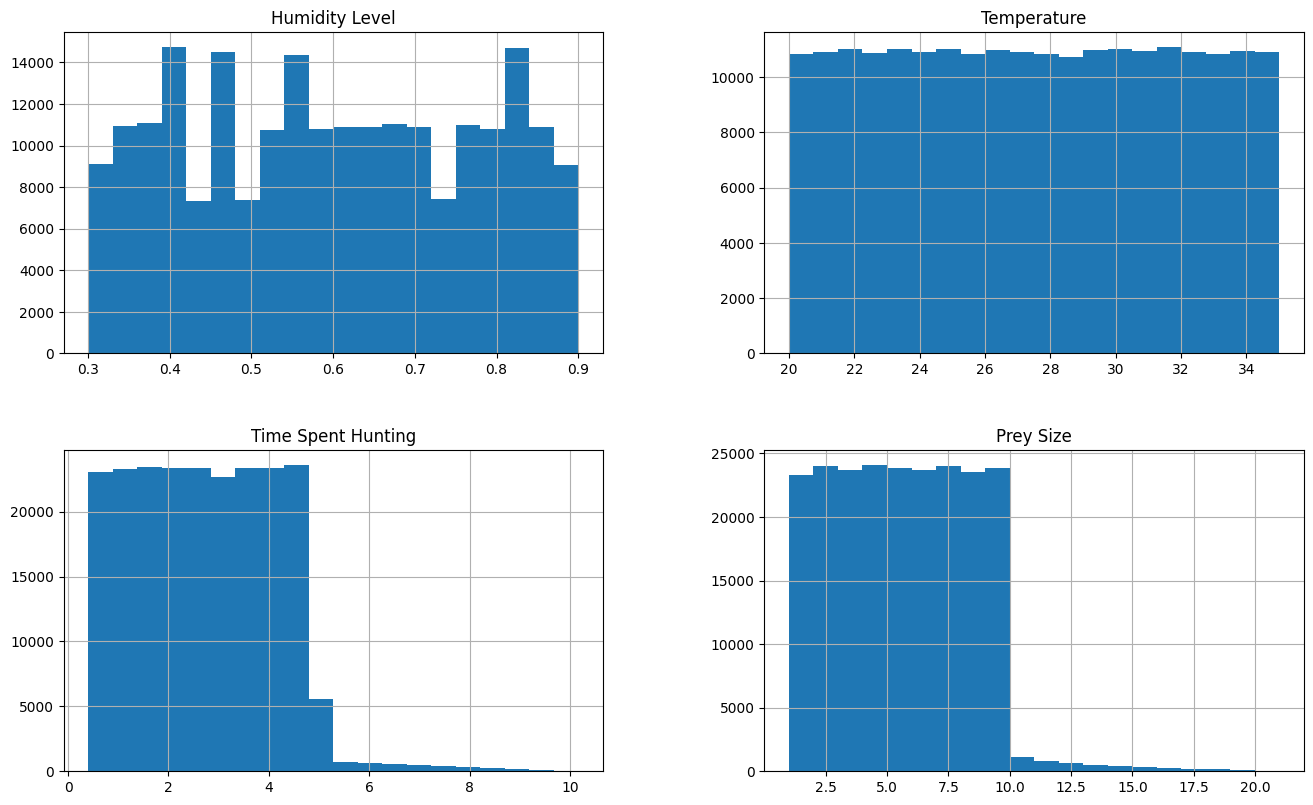

In [17]:
hunting_data[by_unit("g/m^3", "Celcius", "Minutes", "Cm")].hist(bins=20, layout=(2,2), figsize=(16,9.6));

Het is zichtbaar dat de data van temperatuur uniform verdeeld is.
Bij vochtigheid is het niet volledig univorm, sommige nummers komen iets vaker voor dan andere.
De laatste 2 zijn vrij univorm verdeeld, tot een bepaalde waarde (=>5 bij time spent hunting, => 10 bij Prey size). Dit wijst erop dat over het algemeen er minder dan 5 minuten gejaagd wordt. Grotere prooien komen minder vaak voor, wat kan wijzen naar een voorkeur van de mantis.

Ik wil nu de distributies vergelijken van de categorische attributen, "Time of Day" en "Food Availability". Dit wordt gedaan met een barchart

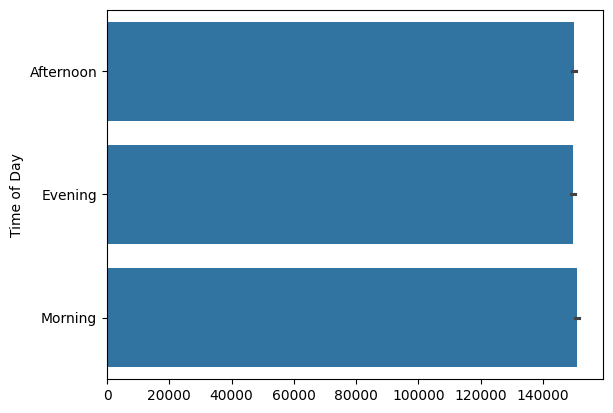

In [18]:
sns.barplot(hunting_data["Time of Day"]);

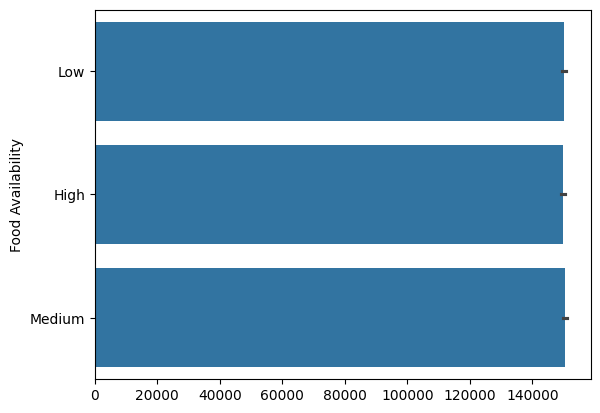

In [19]:
sns.barplot(hunting_data["Food Availability"]);

De 2 categorische features: "Food Availability" en "Time of Day" zijn ook uniform verdeeld


<Axes: >

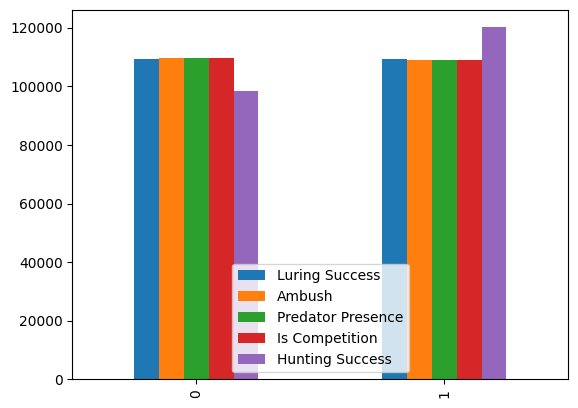

In [20]:
hunting_data[by_unit("True/False", "1/0")].apply(pd.Series.value_counts).plot(kind="bar")

De boolean features zijn ook uniform verdeeld. De verdeling tussen wel en niet is gelijk. Bij hunting success is er zichtbaar dat een geslaagde jacht iets meer voorkomt.

## Bivariate
Ik ga nu kijken naar hoe de continue data: humidity,Temperature, prey size, en time spend hunting in verhouding staat met of een jacht succesvol was of niet.

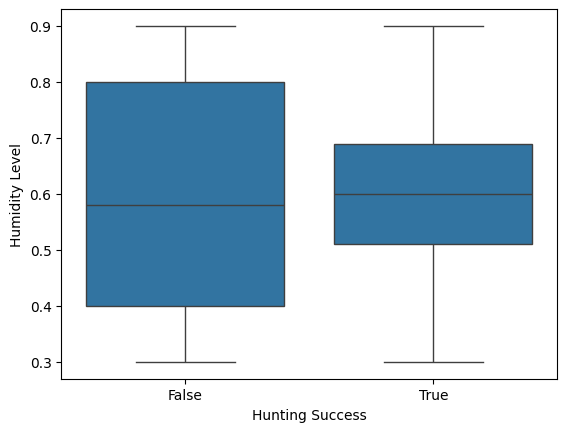

In [21]:
sns.boxplot(y=hunting_data["Humidity Level"], x=hunting_data["Hunting Success"].astype(bool));

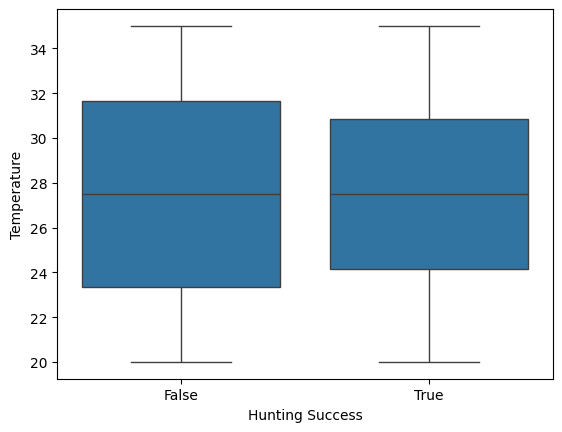

In [22]:
sns.boxplot(y=hunting_data["Temperature"], x=hunting_data["Hunting Success"].astype(bool));

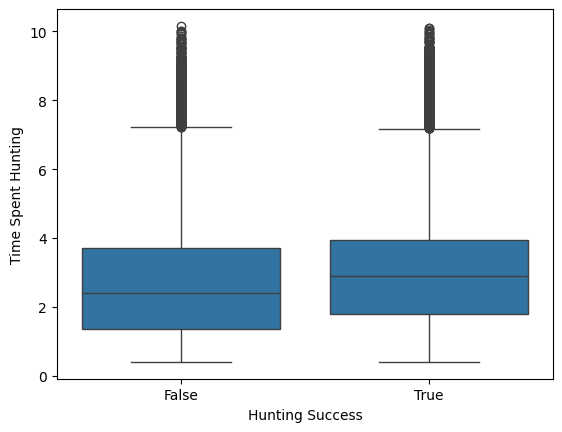

In [23]:
sns.boxplot(y=hunting_data["Time Spent Hunting"], x=hunting_data["Hunting Success"].astype(bool));

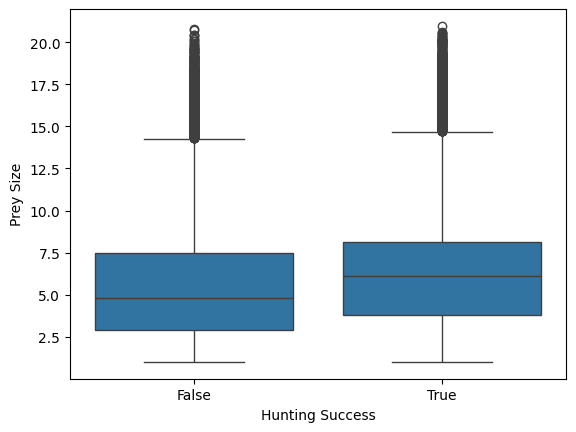

In [24]:
sns.boxplot(y=hunting_data["Prey Size"], x=hunting_data["Hunting Success"].astype(bool));

De IQR van de humidity bij een succesvolle jacht is een stuk kleiner dan bij een niet succesvolle jacht. Dit kan weergeven dat er een optimale vochtigheid is om te gaan jagen.
Bij de andere 3 plotjes komen de boxplotjes wel overeen. Bij Time Spend Hunting en Prey Size ligt de IQR een klein beetje hoger bij een succesvolle jacht.


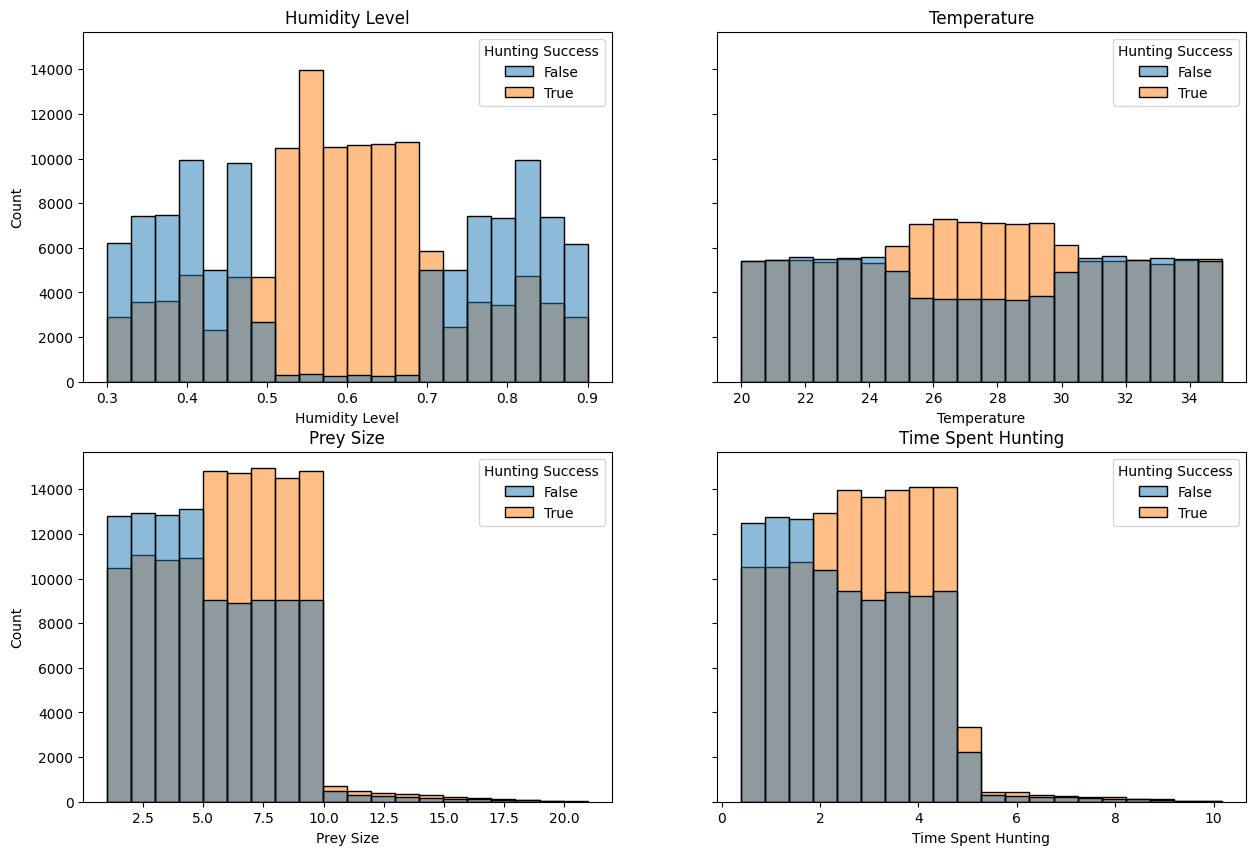

In [ ]:
wanted_columns = ["Humidity Level", "Temperature", "Prey Size", "Time Spent Hunting"]

fix, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10));
index = 0
for i in range(0, 2):
    for j in range(0,2):
        # Put 4 graphs into 1 figure
        sns.histplot(ax = axes[i,j], x=hunting_data[wanted_columns[index]], hue=hunting_data["Hunting Success"].astype(bool), bins=20,multiple='layer');
        axes[i,j].set_title(wanted_columns[index])
        index += 1

Dit geeft weer dat er een optimale vochtigheid en temperatuur blijkt te zijn voor het jagen. Het aantal succesvolle jachten stijgt tussen een vochtigheid van 0.5 en 0.7 G/m^3 en ook bij een temperatuur van 25-28 graden celcius.
Bij time spent hunting en prey size loopt het aantal succesvolle jachten ook een beetje op, maar minder.

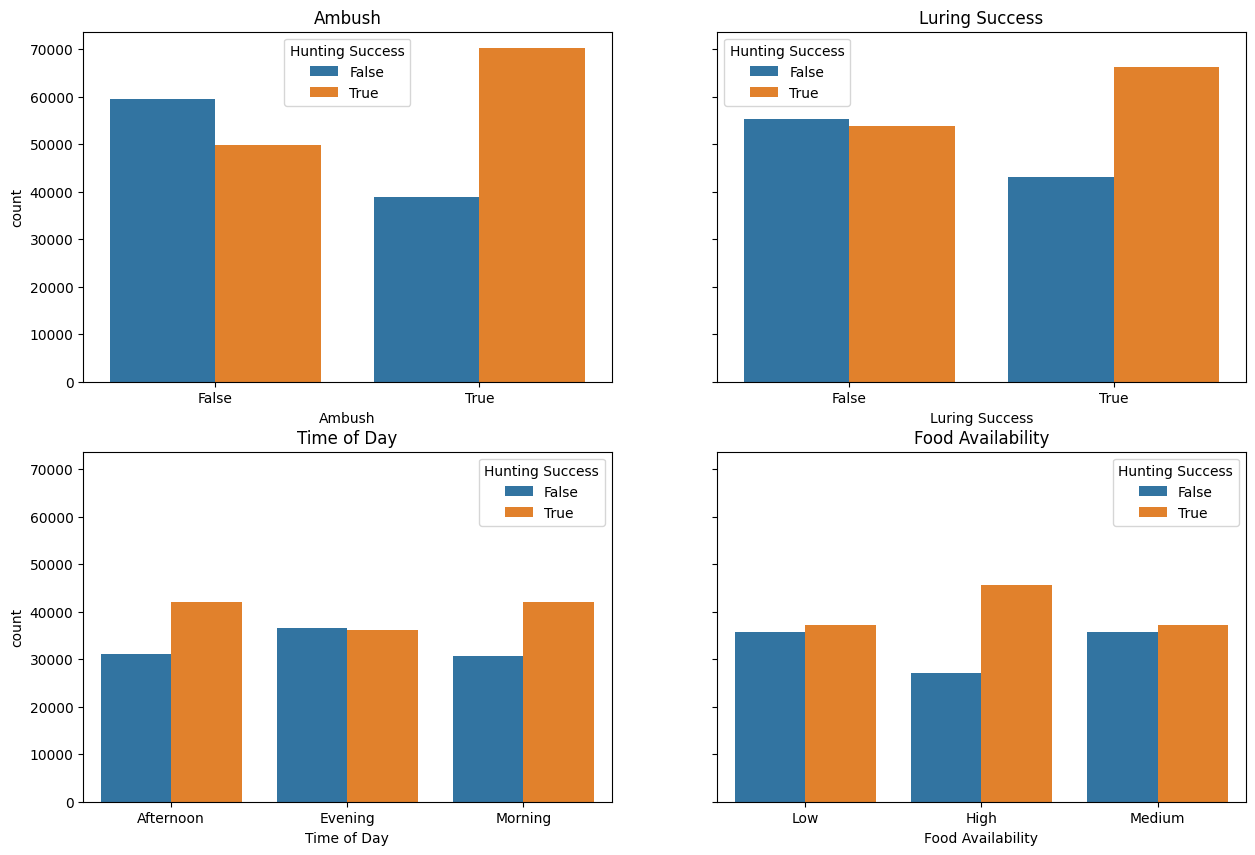

In [ ]:
wanted_columns = ["Ambush", "Luring Success", "Time of Day", "Food Availability"]

fix, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(15, 10));
index = 0

for i in range(0,2):
    for j in range(0,2):
        
        ft = codebook["attribute"].to_list().index(wanted_columns[index])
        # Check if feature is a bool or not, to know how it should be displayed (True/False)
        if codebook["dtype"][ft] == "bool":
            sns.countplot(ax = axes[i,j], x = hunting_data[wanted_columns[index]].astype(bool), hue = hunting_data["Hunting Success"].astype(bool));
        else:
            sns.countplot(ax = axes[i,j], x = hunting_data[wanted_columns[index]], hue = hunting_data["Hunting Success"].astype(bool));
        axes[i,j].set_title(wanted_columns[index])
        index += 1

conclusie:
* Het aantal succesvolle jachten stijgt bij:
    - Wanneer een ambush is toegepast
    - Wanneer luring succesvol is
    - Tijdens de ochtend en de namiddag
    - Wanneer er veel voedsel aanwezig is




Omdat de verhoudingen niet linear zijn kan ik niet gebruik maken van een normale correlatie matrix.
Wel kan ik gebruik maken van een mutual info classifier (MIC) deze zal algemene afhankelijkheden weergeven voor een gekozen variabele (hunting success)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
# Create one hot encoded data for classes
one_hot_food = pd.get_dummies(hunting_data["Food Availability"])
one_hot_time = pd.get_dummies(hunting_data["Time of Day"])

# Add those one hot encodes
X = hunting_data.drop(["Time of Day", "Food Availability", "Hunting Success"], axis=1).join([one_hot_food, one_hot_time])
y = hunting_data["Hunting Success"]

# Calculate MI
mi = mutual_info_classif(X,y)
mi_df = pd.DataFrame(mi, index=X.columns, columns=["MI"])
mi_df.sort_values("MI")


,MI
Time Spent Hunting,0.008905
Morning,0.008952
Afternoon,0.009332
Low,0.010352
Medium,0.010596
Evening,0.011166
Temperature,0.011651
Prey Size,0.014548
High,0.015511
Predator Presence,0.019531


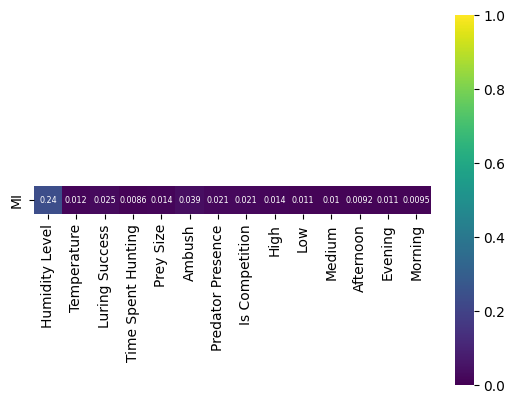

In [32]:
axs = sns.heatmap(mi_df.T, annot=True, annot_kws={"fontsize": "xx-small"}, cmap="viridis", vmin=0.0, vmax=1.0, square=True)

<Axes: >

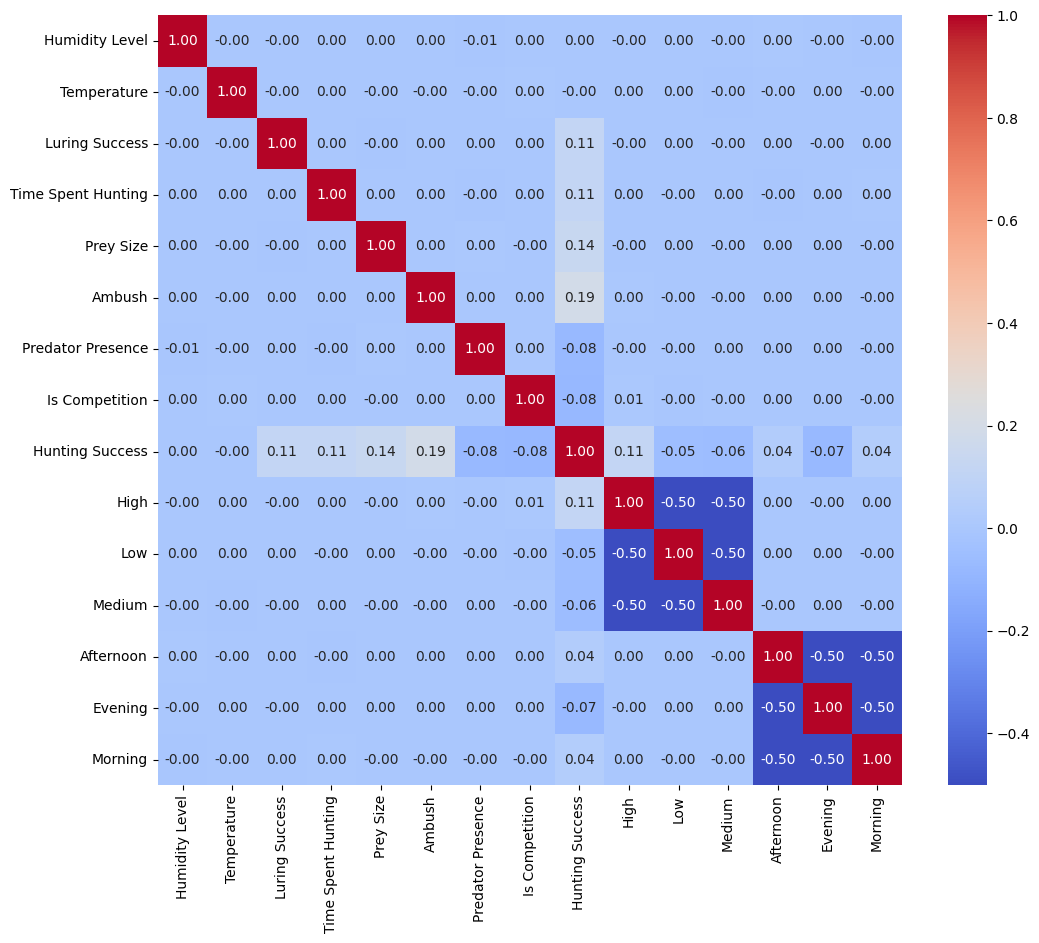

In [48]:
plt.figure(figsize=(12,10))

corr = hunting_data.drop(["Time of Day", "Food Availability"], axis=1).join([one_hot_food, one_hot_time]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

conclusie MI:  
- Humidity heeft de hoogste MI score van 0.24
- Ambush heeft een kleine significantie, kleiner dan humidty
- Luring success heeft ook een kleine significantie
- De time of day blijkt niet veel impact te hebben

Conclusie correlatie:
- Prey size en Ambush hebben de hoogste correlatie met hunting succes (0.14 en 0.19)
- De aanwezigheid van roofdieren en competetie heeft een kleine negatieve correlatie met hunting succes (-0.08)
- De aanwezigheid van veel eten ("high") heeft een kleine correlatie met hunting succes (0.11)
- Bij minder eten is er een kleine negatieve correlatie (-0.05 en -0.06)

In [129]:
X = hunting_data[by_unit("g/m^3", "Celcius", "True/False", "Cm")].to_numpy()
y = hunting_data["Hunting Success"].to_numpy()

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [131]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


In [ ]:
from sklearn.model_selection import cross_validate

# Get cross_valid score
def get_scores(clf, scoring, X, y):
    scores = cross_validate(clf(), X,y, return_train_score=True, scoring=scoring, n_jobs=15)
    for key, val in scores.items():
        scores[key] = val.mean()
    
    return scores

scores = get_scores(DummyClassifier, ["accuracy", "f1", "recall", "precision", "roc_auc",], X, y)
pd.DataFrame(scores.items()).T


,0,1,2,3,4,5,6,7,8,9,10,11
0,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
1,0.018782,0.020726,0.549293,0.549293,0.709088,0.709088,1.0,1.0,0.549293,0.549293,0.5,0.5


In [133]:
scores = get_scores(RandomForestClassifier, ["accuracy", "f1", "recall", "precision", "roc_auc"], X,y)
pd.DataFrame(scores.items()).T


,0,1,2,3,4,5,6,7,8,9,10,11
0,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
1,17.153076,1.884585,0.858892,0.999977,0.874703,0.999979,0.896678,0.999994,0.853779,0.999965,0.940663,1.0


In [134]:
scores = get_scores(GaussianNB, ["accuracy", "recall", "f1", "precision", "roc_auc"], X, y)
pd.DataFrame(scores.items()).T

,0,1,2,3,4,5,6,7,8,9,10,11
0,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_f1,train_f1,test_precision,train_precision,test_roc_auc,train_roc_auc
1,0.060725,0.043116,0.715516,0.715728,0.79144,0.791771,0.753467,0.753685,0.718979,0.719096,0.786772,0.786846


In [135]:
scores = get_scores(DecisionTreeClassifier, ["accuracy", "recall", "f1", "precision", "roc_auc"], X ,y)
pd.DataFrame(scores.items()).T

,0,1,2,3,4,5,6,7,8,9,10,11
0,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_f1,train_f1,test_precision,train_precision,test_roc_auc,train_roc_auc
1,0.80088,0.046565,0.826311,0.999993,0.837305,0.999988,0.841165,0.999994,0.845068,1.0,0.825108,1.0


Conclusie:
- Dummy heeft een accuracy van 54%, wat logisch is omdat de data een beetje scheef is verdeeld (54% en 46%).
- Randomforest doet lang over het fitten, en blijkt ook te overfitten (train accuracy:0.99 > test accuracy:0.85). Ditzelfde geldt voor de recal en de precision.
- GaussianNB classificiteerd ongeveer 72% correct. Heeft een recall en precision die mogelijk wel iets hoger kan. Deze is het best aan het generaliseren.
- DecisionTree is aan het overfitten, train scores van accuracy, recal en precision liggen veel hoger dan bij het testen.

Deze crossvalidatie is uitgevoerd op alle features (behalve de one hot encoded features). Met de MI en en corr matrix zijn er een aantal belangrijke features naar voren gekomen. Ik wil nu deze features gebruiken op deze modellen.

In [ ]:
from sklearn.feature_selection import SelectKBest

# Look at the best features
select = SelectKBest(k=7).fit(X, y)
features = hunting_data[by_unit("g/m^3", "Celcius", "True/False", "Cm")].columns.to_list()

feature_scores = pd.DataFrame({
    "Feature": features,
    "Score": select.scores_
})

# Display best features
feature_scores = feature_scores.sort_values("Score", ascending=False)
feature_scores

,Feature,Score
4,Ambush,8057.943778
3,Prey Size,4084.213239
2,Luring Success,2788.018210
6,Is Competition,1384.194507
5,Predator Presence,1325.537655
0,Humidity Level,0.642614
1,Temperature,0.001124


Dit, samen met de eerder gesteld correlaties geeft weer dat ambush, prey size, luring success, is competition, predator presence heel erg belangrijke features zijn, humidity volgens deze score minder, maar door de MI en correlatie matrix weten we dat die ook relevant is. Deze features neem ik mee naar de volgende test run.

In [136]:
models = [DummyClassifier,
          GaussianNB,
          RandomForestClassifier,
          DecisionTreeClassifier]

In [ ]:
# Add features based on corr, MI and SelectKBest
X_features = hunting_data[["Humidity Level", "Prey Size", "Ambush", "Luring Success", "Is Competition", "Predator Presence"]]
X_train_featues, X_test_features, y_train_features, y_test_features = train_test_split(X_features, y, test_size=0.2,)


In [ ]:
scores = []
# Get scores again for new data
for model in models:
    score = get_scores(model,["accuracy", "recall", "f1", "precision", "roc_auc"], X_features, y)
    
    score["name"] = model.__name__
    scores.append(score)


In [220]:
pd.DataFrame(scores).T

,0,1,2,3
fit_time,0.02453,0.066158,14.850862,0.492462
score_time,0.019934,0.047739,2.031,0.048435
test_accuracy,0.549293,0.711709,0.80072,0.785505
train_accuracy,0.549293,0.71188,0.982595,0.982679
test_recall,1.0,0.789017,0.82029,0.796062
train_recall,1.0,0.789206,0.983903,0.969947
test_f1,0.709088,0.750415,0.818908,0.803041
train_f1,0.709088,0.750574,0.984153,0.984005
test_precision,0.549293,0.715427,0.817534,0.810148
train_precision,0.549293,0.715547,0.984404,0.998476


Dummyclassifier en GaussianNB zijn niet veel veranderd.
Zowel de decisiontree als de forest overfitten nog.
Ik wil kijken of ik hyperparameters van de randomforest kan aanpassen en vervolgens kan beoordelen of ik die ga gebruiken.



In [221]:
from sklearn.model_selection import GridSearchCV

RandomForestClassifier.get_params(RandomForestClassifier())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Ik wil in ieder geval kijken naar de diepte, maximale leaf nodes, mininmale sample split, max_features en minimale sample leafs.
min sample split is het minimale aantal samples die nodig zijn om een node te splitten.
min sample leafs is het minimale aantal samples die nodig zijn om een leaf node te worden.

max_features geeft weer hoeveel features een subsample kan hebben, dit kan via de sqrt(n_features) of log(n_features) bepaald worden.



In [ ]:
params = {
    "max_depth": [10, 15, 20, 25], 
    "max_leaf_nodes": [15, 20, 25],    
    "n_estimators": [50, 100],         
    "min_samples_split": [2, 5, 10],    
    "min_samples_leaf": [1, 2, 4],      
    "max_features": ["sqrt", "log2"]}

# Grid search params
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring="accuracy", n_jobs=30, return_train_score=True)
grid_search.fit(X_train_featues, y_train_features)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=30,
             param_grid={'max_depth': [10, 15, 20, 25],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [15, 20, 25],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100]},
             return_train_score=True, scoring='accuracy')

In [ ]:
cv_results = grid_search.cv_results_

# Get best params, and score
print(f"Best params for random forest: {grid_search.best_params_}")
print(f"Trained accuracy: {cv_results['mean_train_score'][grid_search.best_index_]}")
print(f"Test accuracy: {cv_results['mean_test_score'][grid_search.best_index_]}")

Best params for random forest: {'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Trained accuracy: 0.8488002726432711
Test accuracy: 0.8490961959160677


Het model heeft nu een iets lagere accuracy, maar het blijkt beter te generaliseren. (test en train accuracy zijn bijna hetzelfde)

In [ ]:
# Predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_features)

Nu is er met het gekozen model een prediction gedaan op de test-data. Deze reusltaten wil ik vergelijken met de y-test data. Zo kan ik bepalen of mijn model goed werkt of niet.

array([[16669,  3719],
       [ 2896, 20435]])

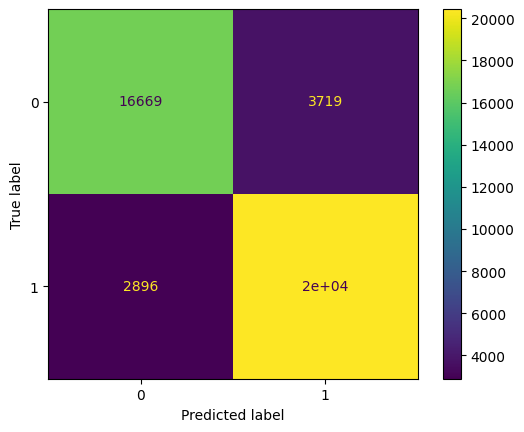

In [232]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

labels = hunting_data["Hunting Success"].drop_duplicates()
matrix = confusion_matrix(y_pred, y_test_features)

ConfusionMatrixDisplay(matrix).plot();
matrix

Zichtbaar is dat true positive en true negative het meeste voorspeld worden.
Er zijn maar 6615 false predicte waarden.

In [ ]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(y_test_features, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.817589,0.851981,0.834430,19565.000000
1,0.875873,0.846030,0.860693,24154.000000
accuracy,0.848693,0.848693,0.848693,0.848693
macro avg,0.846731,0.849005,0.847562,43719.000000
weighted avg,0.849790,0.848693,0.848940,43719.000000


De accuracy is 85%. Dit houd in dat 85% van alle predicties goed voorspeld waren.
Hunting fail heeft een iets groter percentage false positives (precision = 82% vs 88%)
Een succesvolle jacht komt iets vaker voor, maar met een f1-score van ongeveer 85% blijkt het model alsnog goed hiermee om te kunnen gaan.
De recall van beide klassen zijn rond de 85%, wat inhoud dat 85% van de een true positive is, en de overige 15% een false negative.

Omdat dit model probeert te voorspellen of een jacht van een bidsprinkhaan gaat slagen, of niet, op basis van factoren uit de omgeving is het niet een groot probleem om een aantal false positive or false negatives te hebben. De stakes liggen niet heel hoog.
Het model kan met een accuracy van 85% voorspellen of een jacht gaat slagen of niet, hierbij heeft het model een ~85% macro en weighted avg precision en recall, wat inhoud dat er lage false positive en negative predictions zijn.


